# Network-Based Model Building for Discrete Location Allocation in Python: Integrating PySAL and Gurobi

------


### James D. Gaboardi,  David C. Folch

------

### Florida State University,  Department of Geography

---------------

## Python 2.7
## https://www.python.org

-------------------

## PySAL 1.11.0dev
## Python Spatial Analysis Library
## https://www.pysal.readthedocs.org

------------------------

## Gurobi 6.5
## GurobiPy
## http://www.gurobi.com

-------------------

## 1. <u>Optimization in GIS & the Current State</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; • <u>Imports</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; • <u>Open Source</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; • <u>Proprietary</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; • <u>Reproducibility</u>
## 2. <u>Demonstration of PySAL + Gurobi</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; • <u>Imports & Specs</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u>Data Preparation & Creation</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u>Mathematical Optimization</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u>Set Cover Location Problem</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u><i>p</i>-Median Problem</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u><i>p</i>-Center Problem</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u><i>p</i>-Center Problem (Manual LP Creation)</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u>Visualization of Selected Locations</u>
## 3. <u>Next Steps</u>
##  References

-------------------

## <u>Imports</u>

In [1]:
import datetime as dt
import IPython.display as IPd
import os
import platform
from prettytable import from_csv
import sys
import time

# Local Path on user's machine
path = '/Users/jgaboardi/NARSC__15/'

# 1.&nbsp;&nbsp;&nbsp;&nbsp; <u>Optimization & GIS: Current State</u>

## <u>Open Source Software Options</u>

*Many of the software options below don't implement the algorithms we need and this list is not exhaustive.*

In [2]:
# Table of Open-Source software for optimization
OpenOpt = open(path+'NARSC__Optimizers__Open.csv', "r")
OpenTable = from_csv(OpenOpt)
print OpenTable
OpenOpt.close()

+------------------+------------------------+--------------+--------------------------------+
|   Open Source    |          Type          | last updated |             Notes              |
+------------------+------------------------+--------------+--------------------------------+
|     COIN-OR      | Open Source Initiative |              |   many resources associated    |
| CoinGraphClasses |        Library         |              |   network algorithms (COIN)    |
|       CMPL       |        Language        |              |             (COIN)             |
|      CoinMP      |   Interface Library    |              |      supports CLP-CBC-CGL      |
|       CLP        |       LP Solver        |              |         Coin LP (COIN)         |
|       CBC        |      MILP Solver       |              |   Coin Branch-and-Cut (COIN)   |
|       CGL        |        Library         |              | Cut Generation Library (COIN)  |
|     Symphony     |  MILP Solver/Library   |  10/10/2015  |

## <u>Proprietary Software Options</u>

*This list is not exhaustive.*

In [3]:
# Table of Proprietary software for optimization
PropOpt = open(path+'NARSC__Optimizers__Proprietary.csv', "r")
PropTable = from_csv(PropOpt)
print PropTable
PropOpt.close()

+--------------------------+-------------------+--------------------------------+
|       Proprietary        |        Type       |             Notes              |
+--------------------------+-------------------+--------------------------------+
|           AMPL           |   Solver/Modeler  |      30-day student trial      |
|          ArcGIS          |        GIS        |      Network Analyst Tool      |
|          CPLEX           |       Solver      |     free academic license      |
|          Gurobi          |       Solver      |     free academic license      |
| IMSL Numerical Libraries |     Libraries     |                                |
|          Kimeme          |       Solver      |        multi-objective         |
|          Lingo           |       Solver      |                                |
|          Maple           |       Solver      |                                |
|          MATLAB          |       Solver      |      Optimization Toolbox      |
|          MOSEK

## <u>Is it Reproducible?</u>

The following is an example of the workflow for another paper I am currently working on using a traditional method.  This involves manual data input and processing at every step in the schema which tends to decrease efficiency and reproducibility. This is very similar to an Operations Research approach to model building and Operations Research Methodology Diagram (Bertrand and Fransoo 2002, pulp documentation 2009).

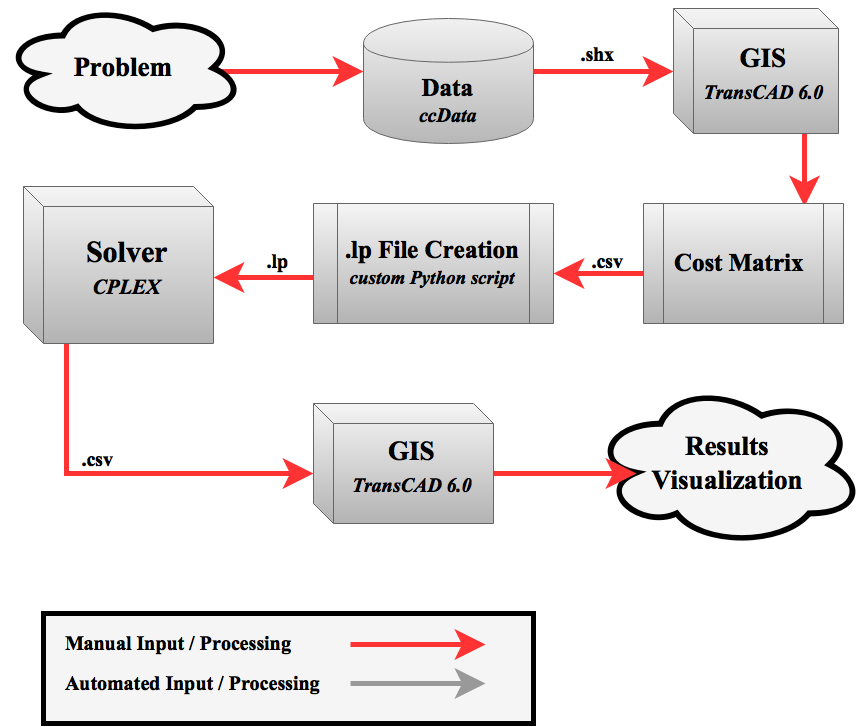

In [4]:
# Manual Conceptual Model
My_Manual = IPd.Image(path+'/Manual_Diagram.png')
My_Manual

## <b>So why do things differently?

When solving spatial problems in a GIS, there are typically lots of files to keep track of and a lot of button clicking. This can lead to compounded errors at every stage in the process.

-------------------

# 2. &nbsp;&nbsp;&nbsp;&nbsp;<u>Demonstration</u>

The following flowchart is a conceptual model of my current workflow.  This workflow mimics the one described above, but the processes within are largely automated to maximize efficiency and reproducibility by minimizing the potential for human error in data handling, etc.  This workflow will be demonstrated next.

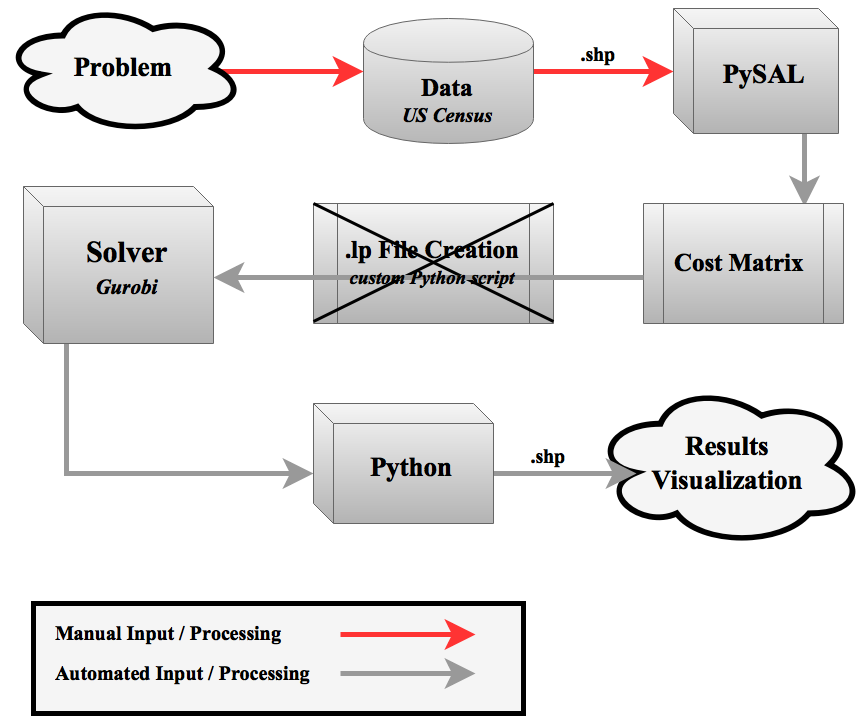

In [5]:
# Automated Conceptual Model
My_Auto = IPd.Image(path+'/Auto_Diagram.png')
My_Auto

## <u>Imports & Specs</u>

In [6]:
from collections import OrderedDict
import gurobipy as gbp
import networkx as nx
import numpy as np
import pysal as ps
from shapely.geometry import Point
import shapefile as shp
%pylab inline

print '********************************************************'
print ' | Platform Specs:                                    |'
print ' |  | OS X v', platform.mac_ver()[0],'                                 |'
print ' |  | Processor: ', platform.processor(), '                               |'
print ' |  | Machine: ', platform.machine(), '                               |'
print ' |  | Python: ', platform.python_version(), '                                 |'
print ' |  | PySAL: ', ps.version, '                              |'
print ' |  | Gurobi: ', gbp.gurobi.version(),'                             |'
print '********************************************************'
print ' |  | Date/Time --------- ', dt.datetime.now(), '|'
print '********************************************************'

Populating the interactive namespace from numpy and matplotlib
********************************************************
 | Platform Specs:                                    |
 |  | OS X v 10.11.1                                  |
 |  | Processor:  i386                                |
 |  | Machine:  x86_64                                |
 |  | Python:  2.7.9                                  |
 |  | PySAL:  1.11.0dev                               |
 |  | Gurobi:  (6, 5, 0)                              |
********************************************************
 |  | Date/Time ---------  2015-11-09 22:07:06.825509 |
********************************************************


## <u>PySAL</u>

Sergio Rey at Arizona State University leads the PySAL project. [https://geoplan.asu.edu/people/sergio-j-rey]

"PySAL is an open source library of spatial analysis functions written in Python intended to support the development of high level applications. PySAL is open source under the BSD License." [https://pysal.readthedocs.org/en/latest/]

I will be only be demonstrating a portion of the functionality in `PySAL.Network`, but there are many other classes and functions for statistical spatial analysis within PySAL.  

In [7]:
print dir(ps)

['Box_Plot', 'DistanceBand', 'Equal_Interval', 'Fisher_Jenks', 'G', 'G_Local', 'Gamma', 'Geary', 'IOHandlers', 'Jenks_Caspall', 'Jenks_Caspall_Forced', 'Jenks_Caspall_Sampled', 'Join_Counts', 'K_classifiers', 'Kernel', 'LISA_Markov', 'MISSINGVALUE', 'Markov', 'Max_P_Classifier', 'Maximum_Breaks', 'Maxp', 'Maxp_LISA', 'Moran', 'Moran_BV', 'Moran_BV_matrix', 'Moran_Local', 'Natural_Breaks', 'Network', 'NetworkF', 'NetworkG', 'NetworkK', 'Percentiles', 'Quantiles', 'SpatialTau', 'Spatial_Markov', 'Std_Mean', 'Tau', 'Theil', 'TheilD', 'TheilDSim', 'Theta', 'User_Defined', 'W', 'WSP', '__builtins__', '__doc__', '__file__', '__name__', '__package__', '__path__', 'adaptive_kernelW', 'adaptive_kernelW_from_shapefile', 'base_path', 'bin', 'bin1d', 'binC', 'block_weights', 'buildContiguity', 'build_lattice_shapefile', 'cg', 'check_version', 'comb', 'common', 'config', 'config_path', 'core', 'datetime', 'directional', 'ergodic', 'esda', 'examples', 'full', 'gadf', 'hexLat2W', 'higher_order', 'hig

## <u>PySAL.Network</u>

`PySAL.Network` was principally developed by Jay Laura at Arizona State Universty and the United States Geological Suvery.  [https://geoplan.asu.edu/people/jay-laura]

In [8]:
print dir(ps.Network)

['NetworkF', 'NetworkG', 'NetworkK', '__doc__', '__init__', '__module__', '_extractnetwork', '_newpoint_coords', '_round_sig', '_snap_to_edge', '_yieldneighbor', 'allneighbordistances', 'compute_distance_to_nodes', 'contiguityweights', 'count_per_edge', 'distancebandweights', 'enum_links_node', 'extractgraph', 'loadnetwork', 'nearestneighbordistances', 'node_distance_matrix', 'savenetwork', 'segment_edges', 'simulate_observations', 'snapobservations']


-----------------

## 2.1 &nbsp;&nbsp;&nbsp;&nbsp;<u>Data preparation and creation</u>

### 2.1.1 &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate a network</u>

First, I start out by instantiating a network by reading a shapefile in as a network object with `PySAL`.  I use Waverly Hills, a smallish neighborhood in Tallahassee, FL where quite a few professors at Florida State University own homes.  This shapefile was clipped from a US Census TIGER/Line file (US Census Bureau 2015).  Additionally, there are some good topological challenges in Waverly Hills that make for good test cases, as seen below.

Note: Steps 3.1.3 through 3.1.7 are needed to create a toy dataset of aggregated population demand points (i.e. households) and service facilities (i.e. school bus stops). These steps are eliminated when reading in actual datasets.

### <u>Loop Road</u>

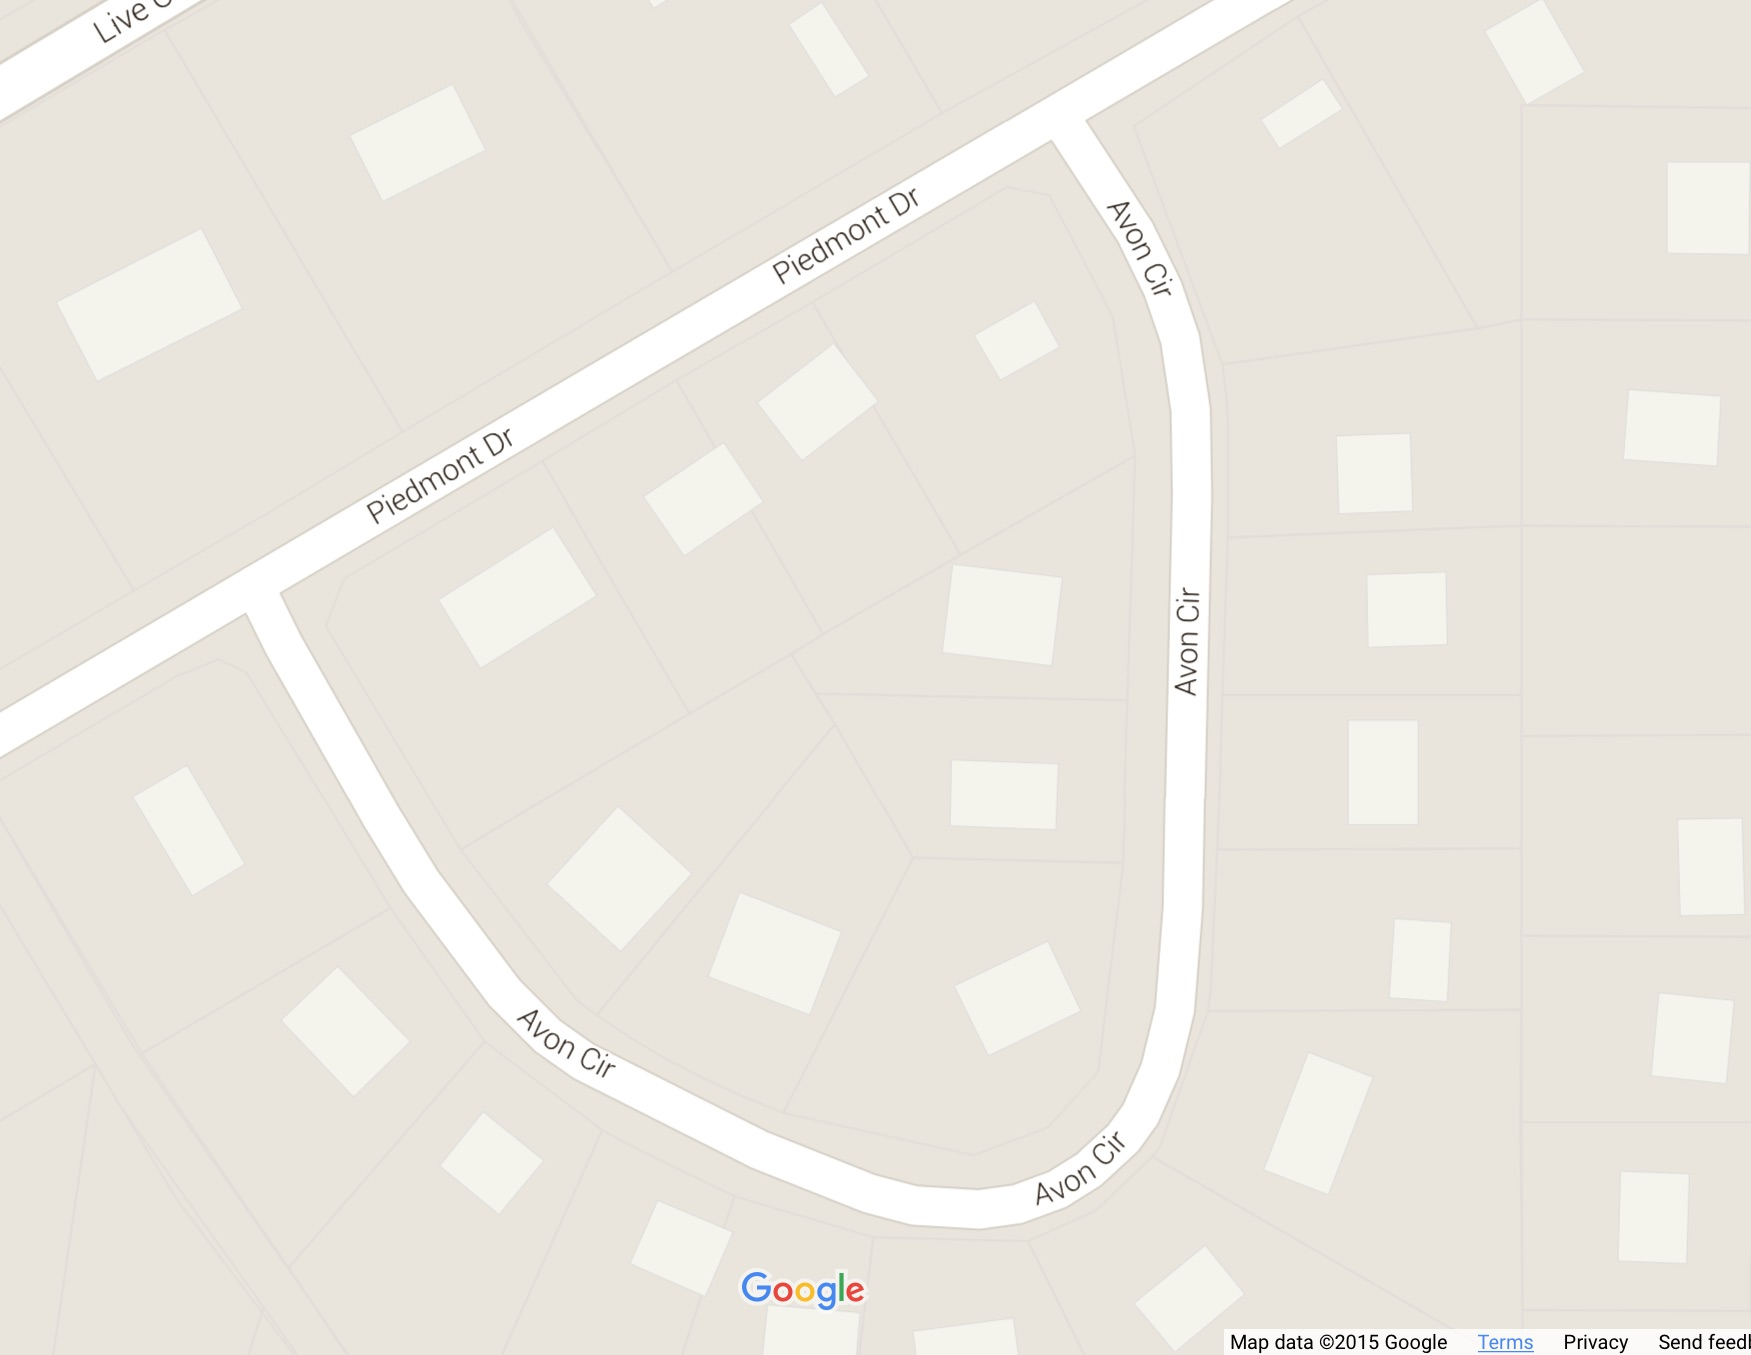

In [9]:
# Avon Circle
Avon_Cir = IPd.Image(path+'/Avon.jpg')
Avon_Cir

### <u>Self-intersecting Road</u>

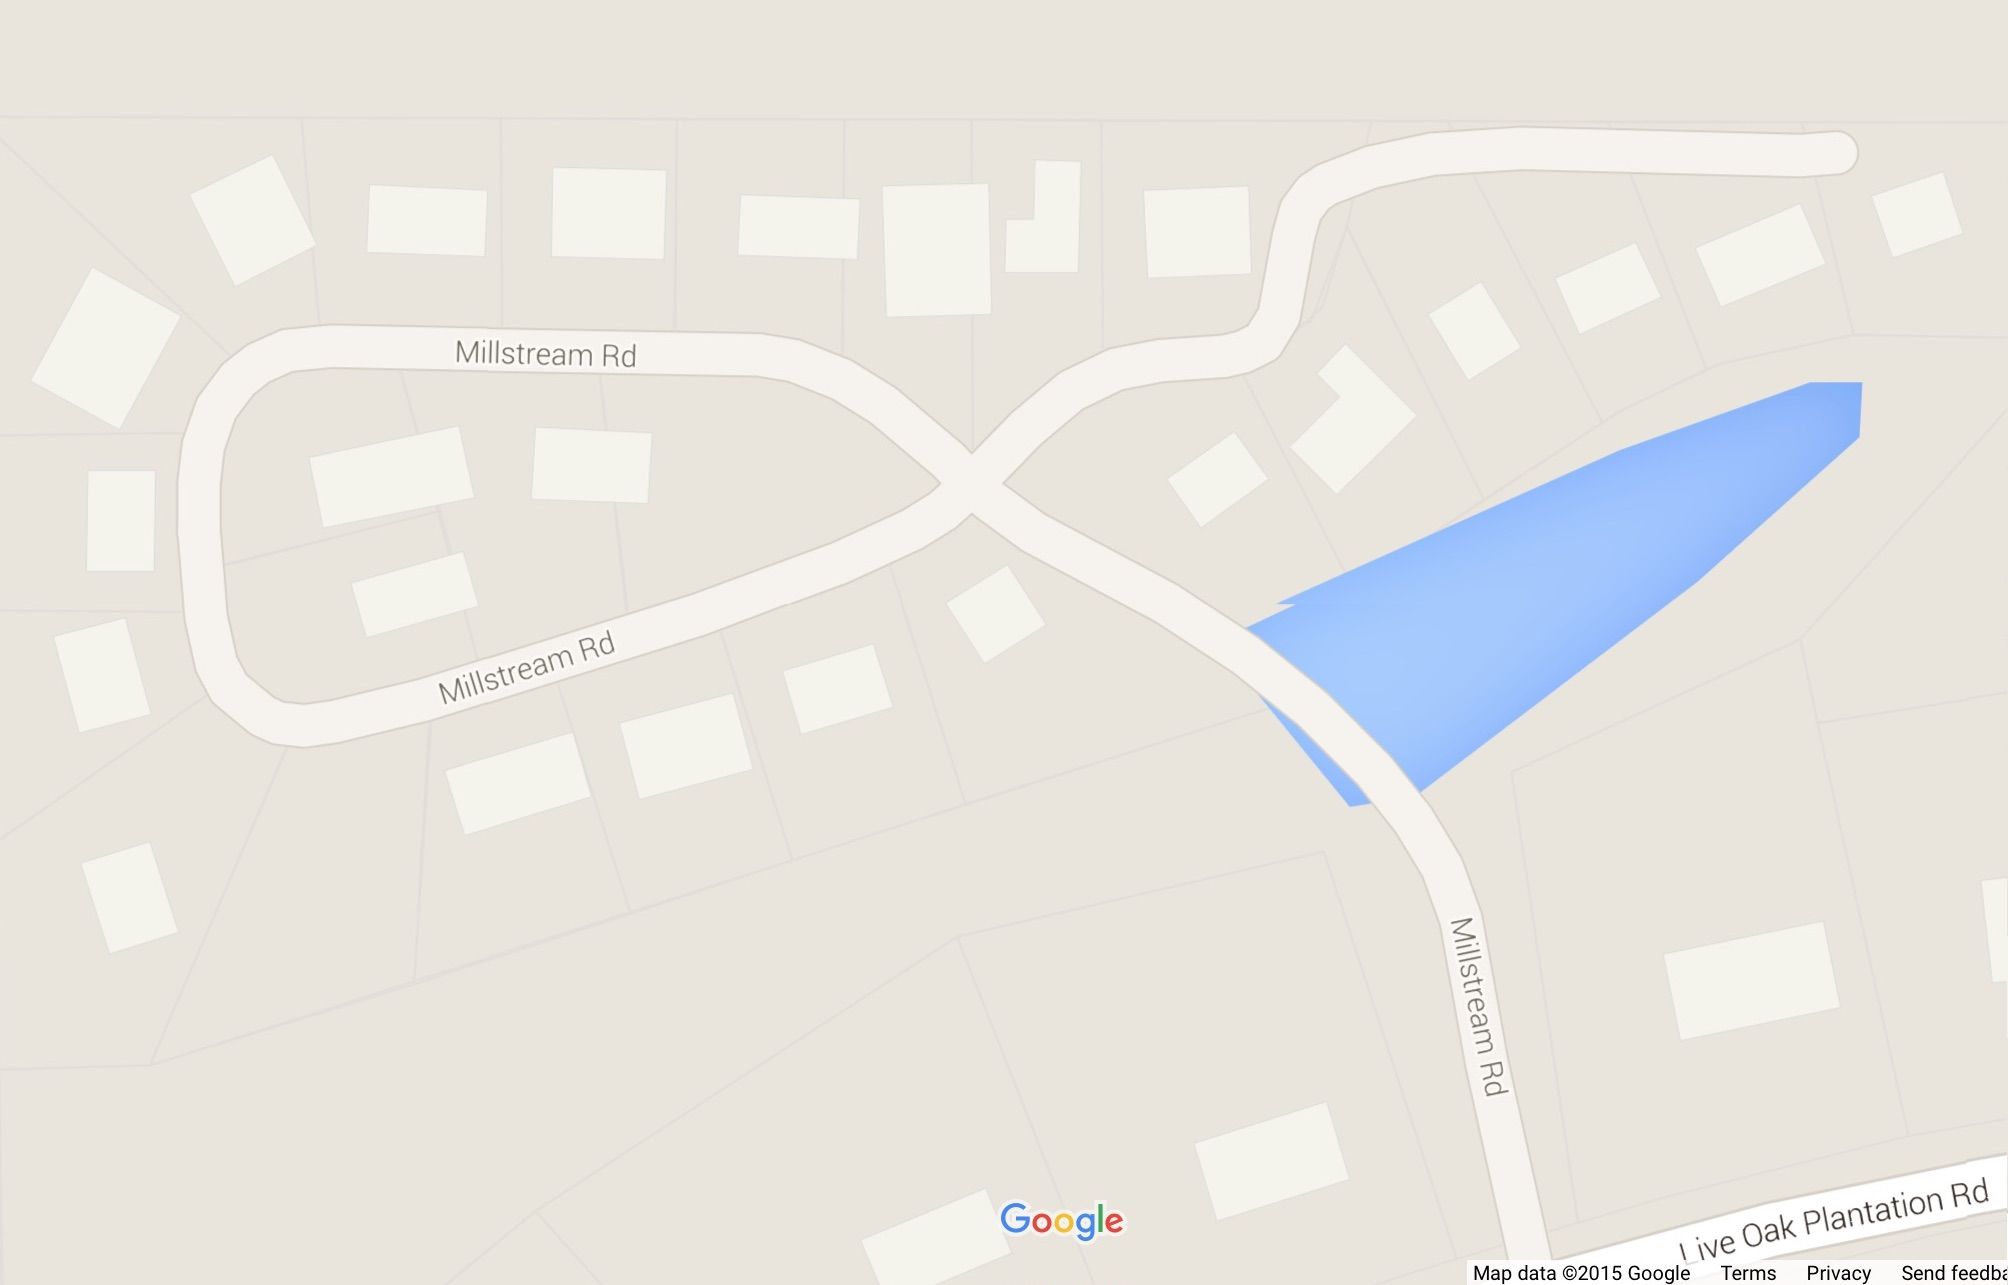

In [10]:
# Millstream Road
Millstream_Rd = IPd.Image(path+'/Millstream.jpg')
Millstream_Rd

In [11]:
# Instanitate network of Waverly Hills
ntw = ps.Network(path+'Waverly/Waverly.shp')

### 2.1.2 &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate all graphs to be drawn</u>

Next, I instantiate the graphs to be drawn for visualization. This includes a representation of edges comprising the road network and nodes for the demand and service nodes. `NetworkX` is utilized for this step.

In [12]:
# Roads and Nodes
g = nx.Graph()

# Graph of Roads and Nodes
g1 = nx.MultiGraph()

# Clients
GRAPH_client = nx.Graph()

# Snapped Clients
g_client = nx.Graph()

# Service
GRAPH_service = nx.Graph()

# Snapped Service
g_service = nx.Graph()

## Optimized Locations
# Set Cover
setcover_g = nx.Graph()

# p-Median
median_g = nx.Graph()

# p-Center
center_g = nx.Graph()

# p-Center Manual
center_g_man = nx.Graph()

### 2.1.3 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create Bounding Box from the roads in 'Waverly.shp'</u>

In [13]:
# Instantiate the Waverly Hills neighborhood shapefile
shp_W = ps.open(path+'Waverly/Waverly.shp')

# Create a bounding box of the shapefile
shp_W.bbox

[-84.27732299999998, 30.470055856478194, -84.25284173452727, 30.49997682517085]

In order to create simulated demand and service nodes for this toy problem I create a bounding latitude and longitude box from the extremes of the 'Waverly.shp' of the Waverly Hills neighborhood. The total area is roughly 1.5 square miles.

### 2.1.4 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create numpy arrays of random floats within a  bounding box</u>

Within the bounding box I create lists of 100 random numbers for the latitude and longitude of demand points (clients), then 15 random numbers for the latitude and longitude of the service points with `Numpy`.

In [14]:
# Client latitude
lat_client = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 100)

# Client longitude
lon_client = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 100)

# Service latitude
lat_service = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 15)

# Service longitude
lon_service = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 15)

### 2.1.5 &nbsp;&nbsp;&nbsp;&nbsp;<u>Zip the latitude and longitude lists together</u>

Next, these four lists are zipped together to form two: a list of client lat/lons and a list and service lat/lons

In [15]:
# Client lat/lon coordinates
rand_coords_client = map(list, zip(lat_client, lon_client))

# Service lat/lon coordinates
rand_coords_service = map(list, zip(lat_service, lon_service))

### 2.1.6 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create Empty Random Points Dictionaries</u>

Dictionaries are instantiated to house the point location data for the simulated client and service facilities.

In [16]:
# Empty Clients dictionary
points_client = {}

# Empty Service dictionary
points_service = {}

### 2.1.7 &nbsp;&nbsp;&nbsp;&nbsp;<u>Fill dictionaries of random roints</u>

The dictionaries that have just been created are now filled with the ids and lat/lons of the points.

In [17]:
# CLIENT with {id: [lon, lat], } format
for idx, coords in enumerate(rand_coords_client):
    GRAPH_client.add_node(idx)
    points_client[idx] = coords
    GRAPH_client.node[idx] = coords

# SERVICE with {id: [lon, lat], } format  
for idx, coords in enumerate(rand_coords_service):
    GRAPH_service.add_node(idx)
    points_service[idx] = coords
    GRAPH_service.node[idx] = coords

### 2.1.8 &nbsp;&nbsp;&nbsp;&nbsp;<u>Draw roads, simplified network, and random client & service nodes</u>

The following is a visualization of the data I have just created and the roads in Waverly Hills using `matplotlib`.  The roads and nodes are derived for network object created in [3.1.1].

Nodes in pink represent the actual intersections and the roads are represented in light red. The simplified network (connecting graph nodes) is gray and the remaining graph nodes (where a choice in forward destination is possible) are red.  These are necessary for determination of a shortest path and may greatly would diminish the computational time. The client nodes are represented in blue and the service nodes are represented in cyan.

2015-11-09 22:07:12.084730


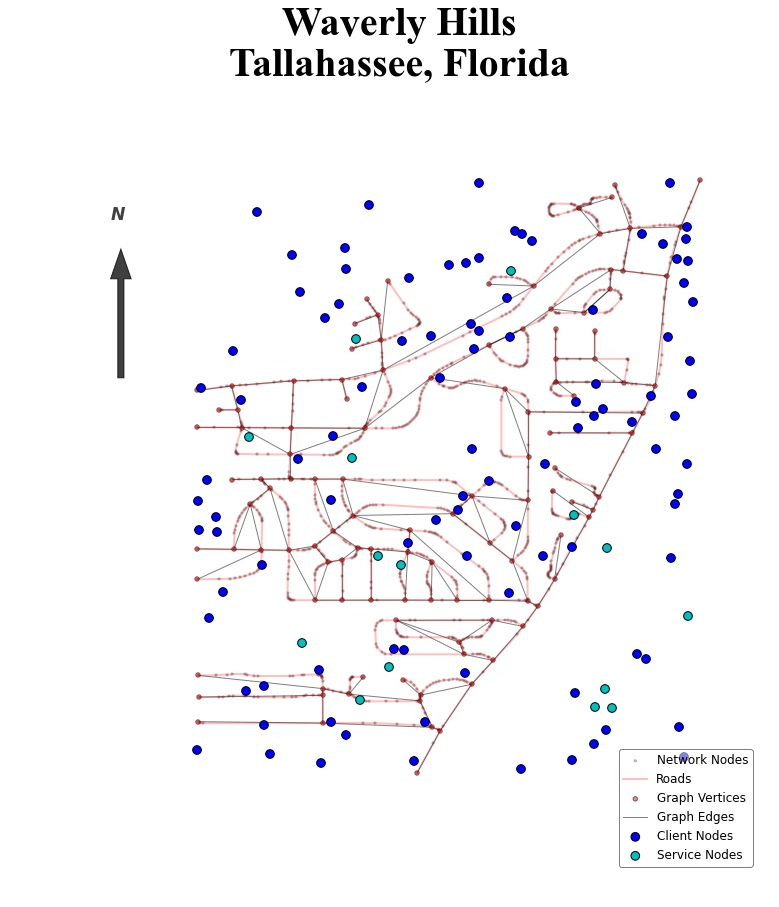

In [18]:
print dt.datetime.now()

#Instantiate Figure
figsize(10,11)

#Draw Graph of Actual Nodes and Roads
for e in ntw.edges:
    g.add_edge(*e)
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)

#Draw only unique edges in graph
for e in ntw.graphedges:
    g1.add_edge(*e)
    # highlights cases where start and end node are the same
    if e[0]==e[1]:
        g1.add_node(e[0])
for node_id in g1.node:
    g1.node[node_id] = ntw.node_coords[node_id]
nx.draw(g1, ntw.node_coords, node_size=20, alpha=0.5)

# Draw Graph of Random Client Points
nx.draw(GRAPH_client, points_client, 
        node_size=75, alpha=1, node_color='b')

# Draw Graph of Random Service Points
nx.draw(GRAPH_service, points_service, 
    node_size=75, alpha=1, node_color='c')

# Legend (Ordered Dictionary) from collections
LEGEND = OrderedDict()
LEGEND['Network Nodes']=g
LEGEND['Roads']=g
LEGEND['Graph Vertices']=g1
LEGEND['Graph Edges']=g1
LEGEND['Client Nodes']=GRAPH_client
LEGEND['Service Nodes']=GRAPH_service
legend(LEGEND, 
       loc='lower right', 
       fancybox=True, 
       framealpha=0.5,
       scatterpoints=1)

# Title
title('Waverly Hills\nTallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')

# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
arrow(-84.281, 30.49, 0.0, 0.005, width=.0003, head_width=0.001, 
          head_length=0.0015, fc='k', ec='k',alpha=0.75,)
annotate('N', xy=(-84.2815, 30.498), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)

### 2.1.9 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create weights at nodes and sum</u>

In order to solve the population weighted problem in this demonstration, the <i>p</i>-median problem, I will `Numpy` to generate a list of 100 random integers [1-5] to represent population at each client node. In this case we can think of the population weight as number of children in the household.

In [19]:
# Client Weights for demand
Ai = np.random.randint(1, 5, len(rand_coords_client))
Ai = Ai.reshape(len(Ai),1)

# Sum of Weights (Total Demand) 
AiSum = np.sum(Ai)

### 2.1.10 &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate client and service shapefiles</u>

Using the python package `shapefile`, I instantiate `.shp` files of the client and service location data that was created above.

In [20]:
# Client Shapefile
client = shp.Writer(shp.POINT)
# Add Random Points
for i,j in rand_coords_client:
    client.point(i,j)
# Add Fields
client.field('client_ID')
client.field('Weight')
client.field('LAT')
client.field('LON')
counter = 0
for i in range(len(rand_coords_client)):
    counter = counter + 1
    client.record('client_' + str(counter), Ai[i], lat_client[i], lon_client[i])
# Save Shapefile    
client.save(path+'Simulated/RandomPoints_CLIENT')

#Service Shapefile
service = shp.Writer(shp.POINT)
# Add Random Points
for i,j in rand_coords_service:
    service.point(i,j)
# Add Fields
service.field('y_ID')
service.field('x_ID')
service.field('LAT')
service.field('LON')
counter = 0
for i in range(len(rand_coords_service)):
    counter = counter + 1
    service.record('y' + str(counter), 'x' + str(counter), lat_service[i], lon_service[i])
# Save Shapefile    
service.save(path+'Simulated/RandomPoints_SERVICE')

### 2.1.11 &nbsp;&nbsp;&nbsp;&nbsp;<u>Snap Observations to NTW</u>

Next, I snap the client and service observations to the network with the `ntw.snapobservations` method within the instantiated network object. This allows for the creation of a distance matrix later.

In [21]:
t1 = time.time()
Snap_C = ntw.snapobservations(path+'Simulated/RandomPoints_CLIENT.shp', 
                     'Rand_Points_CLIENT', attribute=True)
Snap_S = ntw.snapobservations(path+'Simulated/RandomPoints_SERVICE.shp', 
                     'Rand_Points_SERVICE', attribute=True)
print round(time.time()-t1, 4), 'seconds'

2.8193 seconds


### 2.1.12 &nbsp;&nbsp;&nbsp;&nbsp;<u>Draw NTW, snapped coords, & random coords</u>

When the graph is redrawn we can the client and service location in their original locations represented by the smaller points, and the network-snapped location represented with larger points.

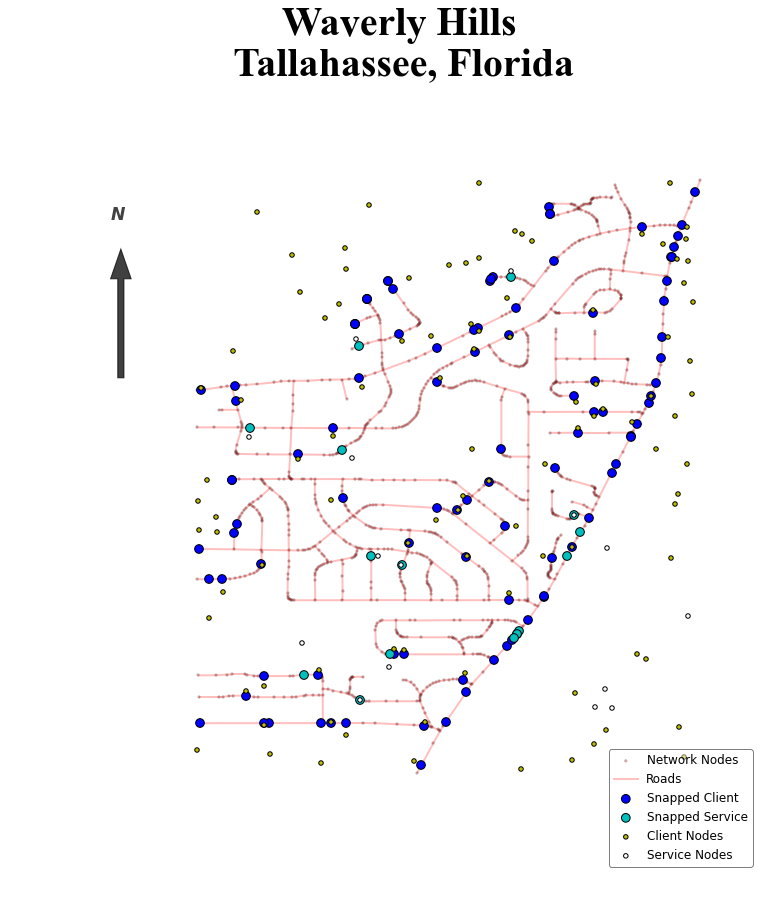

In [22]:
# Instantiate Figure
figsize(10,11)

# Draw Graph of Roads
for e in ntw.edges:
    g.add_edge(*e)
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)

# Draw Graph of Snapped Client Nodes
g_client = nx.Graph()
for p,coords in ntw.pointpatterns['Rand_Points_CLIENT'].snapped_coordinates.iteritems():
    g_client.add_node(p)
    g_client.node[p] = coords
nx.draw(g_client, ntw.pointpatterns['Rand_Points_CLIENT'].snapped_coordinates, 
        node_size=75, alpha=1, node_color='b')

# Draw Graph of Snapped Service Nodes
g_service = nx.Graph()
for p,coords in ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates.iteritems():
    g_service.add_node(p)
    g_service.node[p] = coords
nx.draw(g_service, ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates, 
        node_size=75, alpha=1, node_color='c')

# Draw Graph of Random Client Points
nx.draw(GRAPH_client, points_client, 
    node_size=20, alpha=1, node_color='y')

# Draw Graph of Random Service Points
nx.draw(GRAPH_service, points_service, 
    node_size=20, alpha=1, node_color='w')

# Legend (Ordered Dictionary)
LEGEND = OrderedDict()
LEGEND['Network Nodes']=g
LEGEND['Roads']=g
LEGEND['Snapped Client']=g_client
LEGEND['Snapped Service']=g_service
LEGEND['Client Nodes']=GRAPH_client
LEGEND['Service Nodes']=GRAPH_service
legend(LEGEND, loc='lower right', fancybox=True, framealpha=0.5, scatterpoints=1)

# Title
title('Waverly Hills\n Tallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')

# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
arrow(-84.281, 30.49, 0.0, 0.005, width=.0003, head_width=0.001, 
          head_length=0.0015, fc='k', ec='k',alpha=0.75,)
annotate('N', xy=(-84.2815, 30.498), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)

### 2.1.13 &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate snapped service shapefile</u>

This code chunk is key for representing the results of the optimization problems accurately.  I create a shapefile of the snapped service variable names and their coordinates to be used for comparison later.

In [23]:
# Create Lat & Lon dictionaries of the snapped service locations
lat_snapped = []
lon_snapped = []
for i,j in ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates.iteritems():
    lat_snapped.append(j[0]) 
    lon_snapped.append(j[1])

# Snapped Service Shapefile
service_SNAP = shp.Writer(shp.POINT)
# Add Points
for i,j in ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates.iteritems():
    service_SNAP.point(j[0],j[1])
# Add Fields
service_SNAP.field('y_ID')
service_SNAP.field('x_ID')
service_SNAP.field('LAT')
service_SNAP.field('LON')
counter = 0
for i in range(len(ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates)):
    counter = counter + 1
    service_SNAP.record('y' + str(counter), 'x' + str(counter), lat_snapped[i], lon_snapped[i])
# Save Shapefile    
service_SNAP.save(path+'Snapped/SERVICE_Snapped')

### <b>2.1.14 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create distance matrices</u>

Finally, I create a client to service distance matrix with `ntw.allneighbordistances()` from the instantiated network object of Waverly Hills [`Waverly.shp`].  The matrix is 100x15 and the values are converted from decimal degrees to miles. 

A current limitation of this is run time which is hindered by the geographic size of the network. When tested with much larger client and service point sets the `Dijkstra` algorithm ran in similar time.  This demonstrates the limitation of calculating a shortest-path with the actual road network.  As a potential improvement, the `Dijkstra` may be refactored and calculated on the simplified graph to see decreases in run time. The run time should decrease because there are far fewer nodes and edges in the simplified graph.

In [24]:
t1 = time.time()

# Define Client to Service Matrix Function
def c_s_matrix():
    global All_Dist_MILES
    All_Neigh_Dist = ntw.allneighbordistances(sourcepattern=ntw.pointpatterns['Rand_Points_CLIENT'],
                                             destpattern=ntw.pointpatterns['Rand_Points_SERVICE'])
    All_Dist_MILES = All_Neigh_Dist * float(10000/90) * 0.6214 

# Call Client to Service Matrix Function
c_s_matrix()    

seconds = round(time.time()-t1, 4)    
print seconds, 'seconds'
print 'Client to Service Matrix Shape --> ', All_Dist_MILES.shape

6.6605 seconds
Client to Service Matrix Shape -->  (100, 15)


------------------------

## 2.2 &nbsp;&nbsp;&nbsp;&nbsp;<u>Mathematical Optimization</u>

### 2.2.1a &nbsp;&nbsp;&nbsp;&nbsp;<u>Set Cover test [<i>S</i> = 1.75 miles]</u>

The set cover location problem, also known as the SCLP, is a fundamental facility location problem (Beasley 1987; Daskin 1995; Beasley and Chu 1996).  The objective of the SCLP is to minimize the number of service facilities to site while achieving complete (100%) coverage of client nodes.

## <u>Minimize</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j=1}^n d_j x_j$

## <u>Subject to</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j=1}^n a_{ij} x_j \geq 1,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $i = 1 \in n$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle x_j \in (0,1)$  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $j = 1 \in  m$


## <u>where</u>
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$i$ = a specific origin
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$j$ = a specific destination
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$n$ = the set of origins
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$m$ = the set of destinations
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$x_i$ = the decision variable at each node in the matrix
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$a_{ij}$ = binary matrix describing the coverage of each node

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>where</u>

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;− $a_{ij}$ = $1 \forall i, j \ni d_{ij} \geq S$ ($S$ is user defined) 

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;− $a_{ij} $ = $0$ otherwise

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$d_{ij}$ = distance from $i$th origin to $j$th destination

-----

Adapted from:
- Daskin, M. S. 1995. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

In [25]:
# Define the Set Cover function
def gbpSCLP():    
    
    t1 = time.time()
    
    # Define Global Records Variable
    global NEW_Records_SCLP
    
    #     1. Read In Data
    # Cost Matrix
    Cij = All_Dist_MILES
    # Create Aij: Determine Aij (nodes within S)
    # S --> 1 = served; 0 = unserved
    S = 1.75
    # Aij
    Aij = []
    for i in np.nditer(Cij):
        if i <= S:
            outtext = 1
        else:
            outtext = 0
        Aij.append(outtext)
    rows, cols = Cij.shape
    
    # Transform Aij into an array and resphape to match with Cij
    Aij = np.array(Aij)
    Aij = Aij.reshape(len(Cij),len(Cij[0]))
    
    
    client_nodes = range(len(Cij))
    service_nodes = range(len(Cij[0]))

    #     2. Create Model, Set MIP Focus, Add Variables, & Update Model
    mSCLP = gbp.Model(" -- SCLP -- ")
    
    # Set MIP Focus to 2 for optimality
    gbp.setParam('MIPFocus', 2)

    # Add Service Decision Variables (j)
    serv_var = []
    for dest in service_nodes:
        serv_var.append(mSCLP.addVar(vtype=gbp.GRB.BINARY,
                                    ub = 1,
                                    name='x'+str(dest+1)))
    # Update Model Variables
    mSCLP.update()       

    #     3. Set Objective Function
    mSCLP.setObjective(gbp.quicksum(serv_var[dest] 
                                for dest in service_nodes), 
                                gbp.GRB.MINIMIZE)

    #     4. Add Constraints 
    # Add Coverage Constraints  
    for orig in client_nodes:
        mSCLP.addConstr(gbp.quicksum(Aij[orig][dest]*serv_var[dest] 
                                for dest in service_nodes) >= 1)        

    #     5. Optimize and Print Results
    # Solve
    try:
        mSCLP.optimize()
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'
    
    # Write LP
    mSCLP.write(path+'LP_Files/WaverlySCLP.lp')
    t2 = time.time()-t1
    
    # Record and Display Results
    print '\n*****************************************************************************************'
    selected = []
    dbf1 = ps.open(path+'Snapped/SERVICE_Snapped.dbf')
    NEW_Records_SCLP = []
    for v in mSCLP.getVars():
        if v.x > 0:
            var = '%s' % v.VarName
            selected.append(v.x)
            for i in range(dbf1.n_records):
                if var in dbf1.read_record(i):
                    x = dbf1.read_record(i)
                    NEW_Records_SCLP.append(x)
                else:
                    pass
            print '    |                                                ', var
    print '    | Selected Facility Locations ------------------  ^^^^ '
    print '    | Coverage (S) in miles ------------------------ ', S
    print '    | Client Nodes --------------------------------- ', len(client_nodes)
    print '    | Facilities needed 100% coverage of clients --- ', len(selected)
    print '    | Real Time to Optimize (sec.) ----------------- ', t2
    print '    | Date/Time ------------------------------------ ', dt.datetime.now()
    print '*****************************************************************************************'
    print ' -- Set Cover Location Problem -- '
    
# Call SCLP Function
try:
    gbpSCLP()
    print '\nJames Gaboardi, 2015'
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Optimize a model with 100 rows, 15 columns and 1057 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Found heuristic solution: objective 2
Presolve removed 100 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0%

*****************************************************************************************
    |                                                 x7
    |                                                 x11
    | Selected Facility Locations ------------------  ^^^^ 
    | Coverage (S) in miles ------------------------  1.75
    | Client No

### 2.2.1b&nbsp;&nbsp;&nbsp;&nbsp; <u>Instantiate selected Set Cover location shapefile</u>

Following optimization, I created a new shapefile of the selected candidate service locations.

In [26]:
# Define SCLP shapefile function
def Create_SCLP():
    try:
        # Instantiate SCLP shapefile
        SHP_SetCover = shp.Writer(shp.POINT)
        # Add Points
        for idy,idx,x,y in NEW_Records_SCLP:
            SHP_SetCover.point(float(x), float(y))
        # Add Fields
        SHP_SetCover.field('y_ID')
        SHP_SetCover.field('x_ID')
        SHP_SetCover.field('LAT')
        SHP_SetCover.field('LON')
        # Add Records
        for idy,idx,x,y in NEW_Records_SCLP:
            SHP_SetCover.record(idy,idx,x,y)
        # Save Shapefile    
        SHP_SetCover.save(path+'Results/Selected_Locations_SetCover')
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'

# Call SCLP shapefile function
try:
    Create_SCLP()
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

----------------------------

### 2.2.2a&nbsp;&nbsp;&nbsp;&nbsp;  <u><i>p</i>-Median test [<i>p</i> = 2]</u>

The <i>p</i>-median problem (PMP), also known as the minisum problem, was first proposed by Hakimi in the 1960s and has been utilized in wide-ranging research topics such as Mathematics and Emergency Management since then (Hakimi 1964; Teitz and Bart 1968; Tansel, Francis, and Lowe 1983; Daskin 1995; Horner and Widener 2010; Kalcsics et al. 2014).  This model sites <i>p</i> facilities with an objective of minimizing the total travel cost by siting facilities nearest to the greatest amount of demand.  Weighting decision variables with population, for example, does this.  Efficiency (lowest travel cost) is the key to the PMP. 


## <u>Minimize</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{i \in 1}^n\sum_{j\in 1}^m a_i c_{ij} x_{ij}$

## <u>Subject to</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j\in m} x_{ij}  = 1 ,$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\forall i \in n$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{i \in n} y_j = p$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij} - y_j \geq 0,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n, j \in m$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij}, y_j \in (0,1)$ &nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n , j \in m$

## <u>where</u>

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$i$ = a specific origin
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$j$ = a specific destination
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$n$ = the set of origins
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$m$ = the set of destinations
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$a_i$ = weight at each node
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$c_{ij}$ = travel costs between nodes
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$x_{ij}$ = the decision variable at each node in the matrix
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$y_j$ = nodes chosen as service facilities
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$p$ = the number of facilities to be sited

-----

Adapted from:
- Daskin, M. S. 1995. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

In [27]:
# define p-Median function
def gbpPMP():
    
    t1 = time.time()
    
    # Define Global Variables
    global Ai
    global AiSum
    global NEW_Records_PMP 
    
    #     1. Data
    # Demand
    Ai = Ai
    # Demand Sum
    AiSum = AiSum
    # Travel Costs
    Cij = All_Dist_MILES
    # Weighted Costs
    Sij = Ai * Cij
    # Total Client and Service nodes
    client_nodes = range(len(Sij))
    service_nodes = range(len(Sij[0]))
    
    #     2. Create Model, Set MIP Focus, Add Variables, & Update Model
    # Instantiate Model
    mPMP = gbp.Model(' -- p-Median -- ')
    
    # Set MIP focus to 'Optimal'
    gbp.setParam('MIPFocus', 2)

    # Add Client Decision Variables (iXj)
    client_var = []
    for orig in client_nodes:
        client_var.append([])
        for dest in service_nodes:
            client_var[orig].append(mPMP.addVar(vtype=gbp.GRB.BINARY, 
                                                obj=Sij[orig][dest], 
                                                name='x'+str(orig+1)+'_'+str(dest+1)))
    
    # Add Service Decision Variables (j)
    serv_var = []
    for dest in service_nodes:
        serv_var.append([])
        serv_var[dest].append(mPMP.addVar(vtype=gbp.GRB.BINARY, 
                                        name='y'+str(dest+1)))
    
    # Update the model
    mPMP.update()
    
    #     3. Set Objective Function
    mPMP.setObjective(gbp.quicksum(Sij[orig][dest]*client_var[orig][dest] 
                            for orig in client_nodes for dest in service_nodes), 
                            gbp.GRB.MINIMIZE)
    
    
    #     4. Add Constraints
    # Assignment Constraints
    for orig in client_nodes:
        mPMP.addConstr(gbp.quicksum(client_var[orig][dest] 
                            for dest in service_nodes) == 1)
    # Opening Constraints
    for orig in service_nodes:
        for dest in client_nodes:
            mPMP.addConstr((serv_var[orig][0] - client_var[dest][orig] >= 0))
    
    # Facility Constraint
    mPMP.addConstr(gbp.quicksum(serv_var[dest][0] for dest in service_nodes) == 2)
    
    #     5. Optimize and Print Results
    # Solve
    try:
        mPMP.optimize()
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'
    
    # Write LP
    mPMP.write(path+'LP_Files/WaverlyPMP.lp')
    t2 = time.time()-t1
    
    # Record and Display Results
    print '\n*************************************************************************'
    selected = []
    dbf1 = ps.open(path+'Snapped/SERVICE_Snapped.dbf')
    NEW_Records_PMP = []
    for v in mPMP.getVars():
        if 'x' in v.VarName:
            pass
        elif v.x > 0:
            var = '%s' % v.VarName
            selected.append(var)
            for i in range(dbf1.n_records):
                if var in dbf1.read_record(i):
                    x = dbf1.read_record(i)
                    NEW_Records_PMP.append(x)
                else:
                    pass
            print '    |                                            ', var
    print '    | Selected Facility Locations --------------  ^^^^ '
    print '    | Candidate Facilities [p] ----------------- ', len(selected)
    val = mPMP.objVal
    print '    | Objective Value (miles) ------------------ ', val
    avg = float(mPMP.objVal)/float(AiSum)
    print '    | Avg. Value / Client (miles) -------------- ', avg
    print '    | Real Time to Optimize (sec.) ------------- ', t2
    print '    | Date/Time -------------------------------- ', dt.datetime.now()
    print '*************************************************************************'
    print ' -- The p-Median Problem -- '
    
# Call p-Median Function   
try:
    gbpPMP()
    print '\nJames Gaboardi, 2015'
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

Parameter MIPFocus unchanged
   Value: 2  Min: 0  Max: 3  Default: 0
Optimize a model with 1601 rows, 1515 columns and 4515 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+00]
  Objective range [2e-02, 1e+01]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 2e+00]
Presolve time: 0.01s
Presolved: 1601 rows, 1515 columns, 4515 nonzeros
Variable types: 0 continuous, 1515 integer (1515 binary)
Found heuristic solution: objective 287.0513283
Presolved: 1601 rows, 1515 columns, 4515 nonzeros


Root relaxation: objective 1.891870e+02, 538 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     189.1870407  189.18704  0.00%     -    0s

Explored 0 nodes (538 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 1.891870406981e+02, 

### 2.2.2b&nbsp;&nbsp;&nbsp;&nbsp; <u>Instantiate Selected <i>p</i>-median shapefile</u>

Following optimization, I created a new shapefile of the selected candidate service locations.

In [28]:
# define PMP shapefile function
def Create_PMP():
    try:
        # Instantiate Shapefile
        SHP_Median = shp.Writer(shp.POINT)
        # Add Points
        for idy,idx,x,y in NEW_Records_PMP:
            SHP_Median.point(float(x), float(y))
        # Add Fields
        SHP_Median.field('y_ID')
        SHP_Median.field('x_ID')
        SHP_Median.field('LAT')
        SHP_Median.field('LON')
        # Add Records
        for idy,idx,x,y in NEW_Records_PMP:
            SHP_Median.record(idy,idx,x,y)
        # Save Shapefile    
        SHP_Median.save(path+'Results/Selected_Locations_Pmedian')
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'

# Call PMP shapefile function
try:
    Create_PMP()
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

----------------------

### 2.2.3a  &nbsp;&nbsp;&nbsp;&nbsp;<u><i>p</i>-Center test [<i>p</i> = 2]</u>

The <i>p</i>-center problem (PCP), also referred to as the minimax problem, sites facilities with a focus on equity and has been widely utilized in research as a counter-measure to the efficiency-based <i>p</i>-median problem.  The objective of the PCP is the minimization of the maximum (worst-case) travel cost from client nodes to service facilities (Minieka 1970; Shier 1977; Tansel, Francis, and Lowe 1983; Horner and Widener 2010).

## <u>Minimize</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $W$

## <u>Subject to</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j\in m} x_{ij} = 1,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   $\forall i \in n$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{i \in n} y_j = p$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij} - y_j \geq 0,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\forall i\in n, j \in m$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle W \geq \sum_{j \in m} c_{ij} x_{ij}$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij}, y_j \in (0,1)$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n, j \in m$

## <u>where</u>

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$W$ = the maximum travel cost between client and service nodes
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$i$ = a specific origin
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$j$ = a specific destination
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$n$ = the set of origins
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$m$ = the set of destinations
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$a_i$ = weight at each node
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$c_{ij}$ = travel costs between nodes
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$x_{ij}$ = the decision variable at each node in the matrix
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$y_j$ = nodes chosen as service facilities
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$p$ = the number of facilities to be sited

-----

Adapted from:
- Daskin, M. S. 1995. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

In [29]:
# define PCP shapefile function
def gbpPCP():
    
    t1 = time.time()
    
    # Define Global Variables
    global Cij
    global mPCP
    global dbf1
    global selected_PCP
    global NEW_Records_PCP
    
    #     1. Data
    Cij = All_Dist_MILES
    
    # Total Client and Service nodes
    client_nodes = range(len(Cij))
    service_nodes = range(len(Cij[0]))
    
    #    2. Create Model, Set MIP Focus, Add Variables, & Update Model
    # Instantiate Model
    mPCP = gbp.Model(' -- P-Center -- ')
    # Set MIP focus to 'Optimal'
    gbp.setParam('MIPFocus', 2)
    
    # Add Client Decision Variables (iXj)
    client_var = []
    for orig in client_nodes:
        client_var.append([])
        for dest in service_nodes:
            client_var[orig].append(mPCP.addVar(vtype=gbp.GRB.BINARY, 
                                                obj=Cij[orig][dest], 
                                                name='x'+str(orig+1)+'_'+str(dest+1)))
    # Add Service Decision Variables (j)
    serv_var = []
    for dest in service_nodes:
        serv_var.append([])
        serv_var[dest].append(mPCP.addVar(vtype=gbp.GRB.BINARY, 
                                        name='y'+str(dest+1)))
    
    # Add the Maximum travel cost variable
    W = mPCP.addVar(vtype=gbp.GRB.CONTINUOUS,
                name='W')        
    
    # Update the model
    mPCP.update()  
    
    #     3. Set the Objective function
    mPCP.setObjective(W, gbp.GRB.MINIMIZE)
    
    #     4. Add Constraints
    # Add Assignment Constraints
    for orig in client_nodes:
        mPCP.addConstr(gbp.quicksum(client_var[orig][dest] 
                            for dest in service_nodes) == 1)
    
    # Add Opening constraints
    for orig in service_nodes:
        for dest in client_nodes:
            mPCP.addConstr((serv_var[orig][0] - client_var[dest][orig] >= 0))
    
    # Add Facility Constraints
    mPCP.addConstr(gbp.quicksum(serv_var[dest][0] for dest in service_nodes) == 2)
    
    # Add Maximum travel cost constraints
    for orig in client_nodes:
        mPCP.addConstr(gbp.quicksum(Cij[orig][dest]*client_var[orig][dest]
                            for dest in service_nodes) - W <= 0)
    
    #     5. Optimize and Print Results
    # Solve
    try:
        mPCP.optimize()
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'  
    
    # Write LP
    mPCP.write(path+'/LP_Files/WaverlyPCP.lp')
    t2 = time.time()-t1
    print '\n*************************************************************************'
    
    # Record and Display Results
    selected_PCP = []
    dbf1 = ps.open(path+'Snapped/SERVICE_Snapped.dbf')
    NEW_Records_PCP = []
    for v in mPCP.getVars():
        if 'x' in v.VarName:
            pass
        elif 'W' in v.VarName:
            pass
        elif v.x > 0:
            var = '%s' % v.VarName
            selected_PCP.append(var)
            for i in range(dbf1.n_records):
                if var in dbf1.read_record(i):
                    x = dbf1.read_record(i)
                    NEW_Records_PCP.append(x)
                else:
                    pass
            print '    |                                            ', var,  '         '
    print '    | Selected Facility Locations -------------- ^^^^ ',  '         '
    print '    | Candidate Facilities [p] ----------------- ', len(selected_PCP), '           '
    print '    | Objective Value (miles) ------------------ ', mPCP.objVal, '     '
    print '    | Real Time to Optimize (sec.) ------------- ', t2
    print '    | Date/Time -------------------------------- ', dt.datetime.now()
    print '*************************************************************************'
    print ' -- The p-Center Problem -- '
    
# Call p-Center Function   
try:
    gbpPCP()
    print '\nJames Gaboardi, 2015'
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'    

Parameter MIPFocus unchanged
   Value: 2  Min: 0  Max: 3  Default: 0
Optimize a model with 1701 rows, 1516 columns and 6114 nonzeros
Coefficient statistics:
  Matrix range    [7e-03, 3e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 2e+00]
Presolve time: 0.02s
Presolved: 1701 rows, 1516 columns, 6015 nonzeros
Variable types: 1 continuous, 1515 integer (1515 binary)
Found heuristic solution: objective 2.0346125
Found heuristic solution: objective 2.0208310
Presolve removed 116 rows and 116 columns
Presolved: 1585 rows, 1400 columns, 5551 nonzeros


Root relaxation: objective 1.251377e+00, 939 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.25138    0  310    2.02083    1.25138  38.1%     -    0s
H    0     0                       1.8513018    1.25138  32.4%     -    0s
H    0     0             

### 2.2.3b &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate selected <i>p</i>-Center shapefile</u>

Following optimization, I created a new shapefile of the selected candidate service locations.

In [30]:
# define PCP shapefile function
def Create_PCP():
    try:
        # Instantiate Shapefile
        SHP_Center = shp.Writer(shp.POINT)
        # Add Points
        for idy,idx,x,y in NEW_Records_PCP:
            SHP_Center.point(float(x), float(y))
        # Add Fields
        SHP_Center.field('y_ID')
        SHP_Center.field('x_ID')
        SHP_Center.field('LAT')
        SHP_Center.field('LON')
        # Add Records
        for idy,idx,x,y in NEW_Records_PCP:
            SHP_Center.record(idy,idx,x,y)
        # Save Shapefile    
        SHP_Center.save(path+'Results/Selected_Locations_Pcenter')
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'

# Call PCP shapefile function
try:
    Create_PCP()
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

### 2.2.4a &nbsp;&nbsp;&nbsp;&nbsp;<u>Manual <i>p</i>-Center `.lp` File Creation</u>

The following is a python script I developed to read in the data from a cost matrix and produce a linear/integer programming file. 

In [31]:
# p-Center Facility Location Problem
# This script creates a linear programming file to be read into an optimizer.
'''
GNU LESSER GENERAL PUBLIC LICENSE
                       Version 3, 29 June 2007

 Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
 Everyone is permitted to copy and distribute verbatim copies
 of this license document, but changing it is not allowed.
'''
# Developed by:  James D. Gaboardi, MSGIS
#                03/2015
#                James Gaboardi

#   Terminology & General Background for Facility Location and Summation Notation:

#   *        The objective of the p-center Facility Location Problem is to minimize the maximum cost 
#            of travel between service facilities and clients on a network.

#   *   [i] - a specific origin
#   *   [j] - a specifc destination
#   *   [n] - the set of origins
#   *   [m] - the set of destinations
#   *   [Cij] - travel costs between nodes
#   *   [W] - the maximum travel costs between service facilities and clients 
#   *   [x#_#] - the client decision variable
#   *   [y#] - the service decision variable
#   *   [p] - the number of facilities to be sited

#    DEFINED FUNCTIONS
# Assignment Constraints
def get_assignment_constraints():
    outtext = ' '
    for i in range(1,rows+1):
        temp = ' '
        for j in range(1,cols+1):
            temp += 'x' + str(i) + '_' + str(j) + ' + '
        outtext += temp[:-2] + '= 1\n'
    return outtext

# Facility Constraint  
def get_p_facilities():
    outtext = ''
    for i in range(1, cols+1):
        temp = ''
        temp += 'y' + str(i)
        outtext += temp + ' + '
    outtext = ' ' + outtext[:-2] + '= 2\n'
    return outtext

# Opening Constraints
def get_opening_constraints_p_center():
    outtext = ' '
    for i in range(1, cols+1):
        for j in range(1, rows+1):
            outtext += ' - x' + str(j) + '_' + str(i) + ' + ' + 'y' + str(i) +  ' >= 0\n'
    return outtext

# Maximum Cost Constraints
def get_max_cost():
    outtext = ''
    for i in range(rows):
        temp = '  '
        for j in range(cols):
            temp += str(Cij[i,j]) + ' x' + str(i+1) + '_' + str(j+1) + ' + '
        outtext += temp[:-2] + '- W <= 0\n'
    return outtext

# Declaration of Bounds
def get_bounds_allocation():
    outtext = ' '
    for i in range(rows):
        temp = ''
        for j in range(cols):
            temp += ' 0 <= x' + str(i+1) + '_' + str(j+1) + ' <= 1\n'
        outtext += temp    
    return outtext

def get_bounds_facility():
    outtext = ''
    for i in range(cols):
        outtext += ' 0 <= y' + str(i+1) + ' <= 1\n'
    return outtext

# Declaration of Decision Variables (form can be: Binary, Integer, etc.)
def get_decision_variables_p_center():
    outtext = ' '
    for i in range(1, rows+1):
        temp = ''
        for j in range(1, cols+1):
            temp += 'x' + str(i) + '_' + str(j) + ' '
        outtext += temp
    return outtext
    
def get_facility_decision_variables_p_center():  
    outtext = ''
    for i in range (1, cols+1):
        outtext += 'y' + str(i) + ' '
    return outtext    

#    DATA READS & VARIABLE DECLARATION
Cij = All_Dist_MILES
rows,cols = Cij.shape

#    START TEXT FOR .lp FILE
# Declaration of Objective Function
text = 'Minimize\n'
text += ' obj: W\n'
# Declaration of Constraints
text += 'Subject To\n'                    
text += get_assignment_constraints()
text += get_p_facilities()
text += get_opening_constraints_p_center()
text += get_max_cost()
# Declaration of Bounds
text += 'Bounds\n'
text += get_bounds_allocation()
text += get_bounds_facility()
# Declaration of Decision Variables form: Binaries
text += 'Binaries\n'
text += get_decision_variables_p_center()
text += get_facility_decision_variables_p_center()
text += '\n'
text += 'End\n'
text += "'''\n"
text += "James Gaboardi, 2015"
                
#   CREATE & WRITE .lp FILE TO DISK
# Fill path name  --  File name must not have spaces.
outfile = open(path+'LP_Files/pCenter_Manual.lp', 'w')
outfile.write(text)
outfile.close()

### 2.2.4b &nbsp;&nbsp;&nbsp;&nbsp;<u>Manual <i>p</i>-Center `.lp` File Solved</u>

The `.lp` file created above is then read into Gurobi through `gurobipy` and solved.

In [32]:
# Define manual LP read PCP Function
def Manual_LP_PCP():
    
    global Cij
    global manualPCP
    global dbf1
    global selected_PCP_manual
    global NEW_Records_PCP_Man
    
    t1 = time.time()

    # Instantiate Optimization model from .lp file
    manualPCP = gbp.read(path+'LP_Files/pCenter_Manual.lp')

    # Set MIP focus to 'Optimal'
    gbp.setParam('MIPFocus', 2)

    # Solve
    try:
        manualPCP.optimize()
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'    
    
    t2 = time.time()-t1

    # Record and Display Results
    print '\n*************************************************************************'
    selected_PCP_manual = []
    dbf1 = ps.open(path+'Snapped/SERVICE_Snapped.dbf')
    NEW_Records_PCP_Man = []
    for v in manualPCP.getVars():
        if 'x' in v.VarName:
            pass
        elif 'W' in v.VarName:
            pass
        elif v.x > 0:
            var = '%s' % v.VarName
            selected_PCP_manual.append(var)
            for i in range(dbf1.n_records):
                if var in dbf1.read_record(i):
                    x = dbf1.read_record(i)
                    NEW_Records_PCP_Man.append(x)
                else:
                    pass
            print '    |                                            ', var,  '         '
    print '    | Selected Facility Locations -------------- ^^^^ ',  '         '
    print '    | Candidate Facilities [p] ----------------- ', len(selected_PCP_manual), '           '
    print '    | Objective Value (miles) ------------------ ', manualPCP.objVal, '     '
    print '    | Real Time to Optimize (sec.) ------------- ', t2
    print '    | Date/Time -------------------------------- ', dt.datetime.now()
    print '*************************************************************************'
    print ' -- The p-Center Problem Manual LP Creation-- '
    
# Call Function
try:
    Manual_LP_PCP()
    print '\nJames Gaboardi, 2015'
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'    

Parameter MIPFocus unchanged
   Value: 2  Min: 0  Max: 3  Default: 0
Optimize a model with 1701 rows, 1516 columns and 6114 nonzeros
Coefficient statistics:
  Matrix range    [7e-03, 3e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 2e+00]
Presolve time: 0.03s
Presolved: 1701 rows, 1516 columns, 6015 nonzeros
Variable types: 1 continuous, 1515 integer (1515 binary)
Found heuristic solution: objective 2.0346125
Found heuristic solution: objective 2.0208310
Presolve removed 116 rows and 116 columns
Presolved: 1585 rows, 1400 columns, 5551 nonzeros


Root relaxation: objective 1.251377e+00, 1115 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.25138    0  308    2.02083    1.25138  38.1%     -    0s
H    0     0                       1.8841935    1.25138  33.6%     -    0s
H    0     0            

### 2.2.4c &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate selected manual <i>p</i>-Center shapefile</u>

Following optimization, I create another new shapefile for the selected manual candidate service locations.

In [33]:
# define Manual PCP shapefile function
def Create_PCP_Man():
    try:
        # Instantiate Shapefile
        SHP_Center_Man = shp.Writer(shp.POINT)
        # Add Points
        for idy,idx,x,y in NEW_Records_PCP_Man:
            SHP_Center_Man.point(float(x), float(y))
        # Add Fields
        SHP_Center_Man.field('y_ID')
        SHP_Center_Man.field('x_ID')
        SHP_Center_Man.field('LAT')
        SHP_Center_Man.field('LON')
        # Add Records
        for idy,idx,x,y in NEW_Records_PCP_Man:
            SHP_Center_Man.record(idy,idx,x,y)
        # Save Shapefile    
        SHP_Center_Man.save(path+'Results/Selected_Locations_Pcenter_Man')
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'

# Call Manual PCP shapefile function
try:
    Create_PCP_Man()
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

### 2.2.4d &nbsp;&nbsp;&nbsp;&nbsp;<u><i>p</i>-Center Results compared</u>

Comaprison of the automated and manual p-Center solution results:

In [34]:
print ' \n Automated p-Center'
print '    | Candidate Facilities [p] ----------------- ', len(selected_PCP), '           '
print '    | Selected Facility Locations -------------- ', selected_PCP
print '    | Objective Value (miles) ------------------ ', mPCP.objVal, '     '

print '\n Manual p-Center'
print '    | Candidate Facilities [p] ----------------- ', len(selected_PCP_manual), '           '
print '    | Selected Facility Locations -------------- ', selected_PCP_manual
print '    | Objective Value (miles) ------------------ ', manualPCP.objVal, '     '

print '\n\n    | Same Objective Value  -------------------- ', str(mPCP.ObjVal) == str(manualPCP.ObjVal)
print '    | Same Facilities  ------------------------- ', selected_PCP == selected_PCP_manual

 
 Automated p-Center
    | Candidate Facilities [p] -----------------  2            
    | Selected Facility Locations --------------  ['y4', 'y5']
    | Objective Value (miles) ------------------  1.42434172323      

 Manual p-Center
    | Candidate Facilities [p] -----------------  2            
    | Selected Facility Locations --------------  ['y4', 'y5']
    | Objective Value (miles) ------------------  1.42434172323      


    | Same Objective Value  --------------------  True
    | Same Facilities  -------------------------  True


-------------

## 2.3 &nbsp;&nbsp;&nbsp;&nbsp;<u>Selected locations</u></b>

In the final step, I visualize the selected locations on the SCLP, PMP, and PCP by calling the shapefiles created after optimizing the problems. 

The following plot shows the optimal locations as represented by snapped coordinates of the service sites. 

Of particular note is the frequent discrepency of the optimal candidate locations between the PCP solutions. Although the objective value appears to be equal (or is nearly equal) after every trial, the PCP model built and solved with `gurobipy` consistently runs nearly double the simplex iterations with only a fraction of a second longer run time suggesting a more robust solution.  

### Selected Set Cover, <i>p</i>-median, and <i>p</i>-center locations</u>

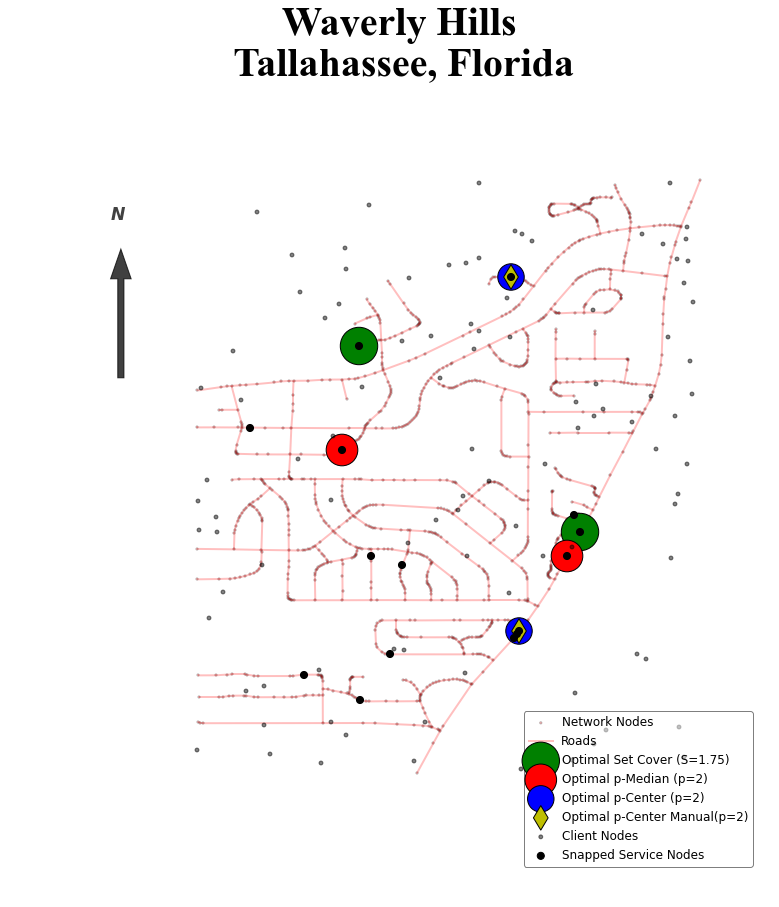

In [35]:
figsize(10,11)
# Draw Network Actual Roads and Nodes
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)

# Set Cover
SetCover = ps.open(path+'Results/Selected_Locations_SetCover.shp')
points_setcover = {}
for idx, coords in enumerate(SetCover):
    setcover_g.add_node(idx)
    points_setcover[idx] = coords
    setcover_g.node[idx] = coords
nx.draw(setcover_g, points_setcover, 
        node_size=1400, alpha=1, node_color='g')

# p-Median
P_Med = ps.open(path+'Results/Selected_Locations_Pmedian.shp')
points_median = {}
for idx, coords in enumerate(P_Med):
    median_g.add_node(idx)
    points_median[idx] = coords
    median_g.node[idx] = coords
nx.draw(median_g, points_median, 
        node_size=1000, alpha=1, node_color='r')

# p-Center
P_Cent = ps.open(path+'Results/Selected_Locations_Pcenter.shp')
points_center = {}
for idx, coords in enumerate(P_Cent):
    center_g.add_node(idx)
    points_center[idx] = coords
    center_g.node[idx] = coords
nx.draw(center_g, points_center, 
        node_size=700, alpha=1, node_color='b')

# p-Center Manual
P_Cent_Man = ps.open(path+'Results/Selected_Locations_Pcenter_Man.shp')
points_center_man = {}
for idx, coords in enumerate(P_Cent_Man):
    center_g_man.add_node(idx)
    points_center_man[idx] = coords
    center_g_man.node[idx] = coords
nx.draw(center_g_man, points_center_man, 
        node_size=300, alpha=1, node_color='y', node_shape='d' )

# Draw Graph of Random Client
nx.draw(GRAPH_client, points_client, 
        node_size=15, alpha=.5, node_color='k')

# Draw Graph of Snapped Service
nx.draw(g_service, ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates, 
        node_size=50, alpha=1, node_color='k')

# Legend (Ordered Dictionary)
LEGEND = OrderedDict()
LEGEND['Network Nodes']=g
LEGEND['Roads']=g
LEGEND['Optimal Set Cover (S=1.75)']=setcover_g
LEGEND['Optimal p-Median (p=2)']=median_g
LEGEND['Optimal p-Center (p=2)']=center_g
LEGEND['Optimal p-Center Manual(p=2)']=center_g_man
LEGEND['Client Nodes']=GRAPH_client
LEGEND['Snapped Service Nodes']=g_service
legend(LEGEND, 
       loc='lower right', 
       fancybox=True, 
       framealpha=0.5, 
       scatterpoints=1)

# Title
title('Waverly Hills\n Tallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')

# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
arrow(-84.281, 30.49, 0.0, 0.005, width=.0003, head_width=0.001, 
          head_length=0.0015, fc='k', ec='k',alpha=0.75,)
annotate('N', xy=(-84.2815, 30.498), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)

---------------------

# 3. <u>Next Steps</u>

- Potential for refactoring the Dijkstra algorithm in `PySAL.Network` to increase efficiency

- Improve cases for determining the simplified network to tackle to issue of network size

- Integrate PySAL with an open source solver

----------------

# GitHub 
# https://github.com/jGaboardi/Facility_Location

------------------------

In [37]:
IPd.HTML('https://github.com/jGaboardi')

---------------